In [2]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import argparse
import os
import time
from pathlib import Path

import voice_cloning

from voice_cloning.encoder.inference import load_model as load_speaker_encoder

from fastspeech2.dataset import Dataset
from fastspeech2.optimizer import ScheduledOptim
from fastspeech2.hparams import HyperParameters as hp
import fastspeech2.utils as utils
from fastspeech2.audio import tools as audiotools
from voice_cloning.encoder import params_data

/home/rokas/year4/mlp/cw3/Real-Time-Voice-Cloning/voice_cloning/encoder/audio.py:13: UserWarning: Unable to import 'webrtcvad'. This package enables noise removal and is recommended.
  warn("Unable to import 'webrtcvad'. This package enables noise removal and is recommended.")


In [3]:
# Get device
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

# Get dataset
dataset = Dataset("train.txt")
loader = DataLoader(dataset, batch_size=128, shuffle=True,
                    collate_fn=dataset.collate_fn, drop_last=True, 
                    num_workers=4)

speaker_encoder = None
if hp.speaker_encoder_path != "":
    speaker_encoder = load_speaker_encoder(Path(hp.speaker_encoder_path), device).to(device)
    if not hp.train_speaker_encoder:
        for param in speaker_encoder.parameters():
            param.requires_grad = False

# Define model
model = speaker_encoder.to(device).eval()

Loaded encoder "pretrained.pt" trained to step 1564501


In [4]:
speaker_embeddings = {}
total = 0
for i, batchs in enumerate(loader):
    for j, data_of_batch in enumerate(batchs):
        # Get Data
        text = torch.from_numpy(data_of_batch["text"]).long().to(device)
        mel_target = torch.from_numpy(data_of_batch["mel_target"]).float().to(device)
        D = torch.from_numpy(data_of_batch["D"]).long().to(device)
        log_D = torch.from_numpy(data_of_batch["log_D"]).float().to(device)
        f0 = torch.from_numpy(data_of_batch["f0"]).float().to(device)
        energy = torch.from_numpy(data_of_batch["energy"]).float().to(device)
        src_len = torch.from_numpy(data_of_batch["src_len"]).long().to(device)
        mel_len = torch.from_numpy(data_of_batch["mel_len"]).long().to(device)
        max_src_len = np.max(data_of_batch["src_len"]).astype(np.int32)
        max_mel_len = np.max(data_of_batch["mel_len"]).astype(np.int32)

        embeddings = model(mel_target[:, :, :params_data.mel_n_channels])
        for i in range(len(embeddings)):
            speaker = data_of_batch["id"][i].split("_")[0][1:]
            embedding = embeddings[i].cpu().numpy()
            if speaker in speaker_embeddings.keys():
                speaker_embeddings[speaker].append(embedding)
            else:
                speaker_embeddings[speaker] = [embedding]
        total += len(embeddings)
        if total > 1000:
            break  
    if total > 1000:
            break

In [5]:
speaker_avg = np.zeros((len(speaker_embeddings.keys()), 256))
for i, key in enumerate(speaker_embeddings.keys()):
    arr = np.array(speaker_embeddings[key])
    mean = np.mean(arr, axis=0) 
    speaker_avg[i] = mean

In [6]:
from sklearn.metrics.pairwise import cosine_similarity as sim
similarity = sim(speaker_avg, speaker_avg)                

['236', '363', '254', '308', '281', '263', '282', '277', '246', '275', '269', '271', '272', '323', '266']


[Text(0, 0, '236'),
 Text(0, 0, '363'),
 Text(0, 0, '254'),
 Text(0, 0, '308'),
 Text(0, 0, '281'),
 Text(0, 0, '263'),
 Text(0, 0, '282'),
 Text(0, 0, '277'),
 Text(0, 0, '246'),
 Text(0, 0, '275'),
 Text(0, 0, '269'),
 Text(0, 0, '271'),
 Text(0, 0, '272'),
 Text(0, 0, '323'),
 Text(0, 0, '266')]

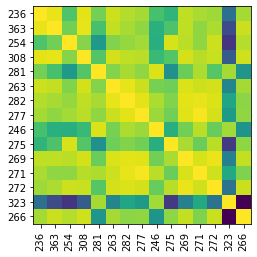

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

n = 15
labels = list(speaker_embeddings.keys())[:n]
print(labels)

fig, ax = plt.subplots(1,1)
ax.imshow(similarity[:n, :n])
plt.xticks(np.arange(0, n))
plt.yticks(np.arange(0, n))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_yticklabels(labels)


In [11]:
speaker_embeddings.keys()

dict_keys(['236', '363', '254', '308', '281', '263', '282', '277', '246', '275', '269', '271', '272', '323', '266', '255', '317', '278', '265', '260', '347', '239', '250', '244', '334', '226', '329', '310', '238', '270', '314', '267', '279', '339', '376', '256', '249', '299', '230', '259', '292', '311', '276', '283', '234', '303', '316', '297', '268', '280', '233', '312', '307', '301', '286', '313', '361', '284', '364', '298', '304', '374', '360', '336', '229', '288', '252', '294', '305', '326', '237', '232', '274', '243', '227', '264', '300', '333', '261', '306', '273', '248', '287', '231', '330', '293', '247', '251', '228', '258', '241', '225', '285', '245', '351', '302', '253', '343', '295', '335', '318', '240', '340', '362', '341', '257', '345', '262'])